In [1]:
# Import packages
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
import torch.optim as optim

In [2]:
# dataset and prep
#data_type = "letters"
data_type = "letters"

from torchvision import datasets, transforms

# Define a transform to normalize the data
#transform = transforms.Compose([transforms.ToTensor(),
#                              transforms.Normalize((0,), (1,)),
#                              ])
transform=transforms.Compose([lambda img: torchvision.transforms.functional.rotate(img, -90),
                                                                    transforms.RandomHorizontalFlip(p=1),
                                                                    transforms.ToTensor()])

# Download and load the training data
trainset = datasets.EMNIST('drive/My Drive/emnist2/EMNIST_data/', download=True, split=data_type, train=True, transform=transform)  
valset = datasets.EMNIST('drive/My Drive/emnist2/EMNIST_data/', download=True, split=data_type, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=True)

C:\Users\samet\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
#This helper funcation convert the output index [0-61] into character [0-9],[A-Z],[a-z]

def to_char(num):
    if num<10:
        return str(num)
    elif num < 36:
        return chr(num+55)
    else:
        return chr(num+61)


# This is reverse of above function. Convert character [0-9],[A-Z],[a-z] into index [0-61]
def to_index(char):
    if ord(char)<59:
        return ord(char)-48
    elif ord(char)<95:
        return ord(char)-55
    else:
        return ord(char)-61


In [4]:

def to_char(num):
    if num<27:
        return chr(num)
def to_index(char):
    if ord(char)<27:
        return ord(char)-1

In [5]:
#Using this function you can see the image and its label form the dataset

def show_example(data):
    img, label = data
    print("Label: ("+to_char(label)+")")
    plt.imshow(img[0], cmap="gray")

In [6]:
# CNN

if data_type=="letters":
    num_class=47
else:
    num_class=10

from torch import nn
from torch.nn import functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 47)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization
# Initialize model
model = CNN()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

model.to(device)

Using device: cuda:0


CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=47, bias=True)
)

In [7]:

def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.cpu().data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze(), cmap='gray')
    ax1.axis('off')
    ax2.barh(np.arange(num_class), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(num_class))
    ax2.set_yticklabels(np.arange(num_class))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()
    plt.savefig('digit.png',  bbox_inches='tight')

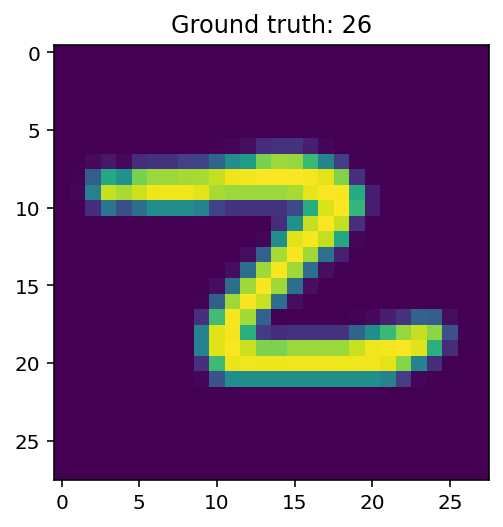

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img, label):
    plt.imshow(img.reshape((28, 28)))
    plt.title('Ground truth: ' + str(label.item()))
    
X, y = iter(trainloader).next()
imshow(X[0], y[0])

In [9]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([32, 1, 28, 28])
torch.Size([32])


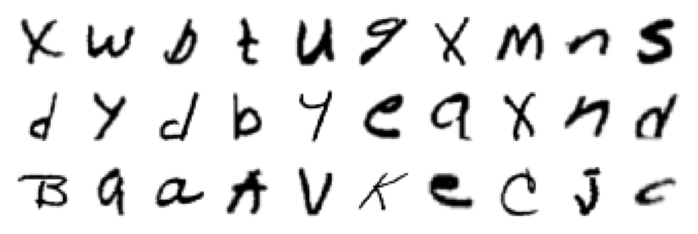

In [10]:
figure = plt.figure()
num_of_images = 30
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [11]:
next(model.parameters()).is_cuda # returns a boolean

True

In [12]:
model = CNN()
model.load_state_dict(torch.load('models/CNN_letters.pth'))
model.to(device)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=47, bias=True)
)

In [13]:
test_output, last_layer = model(images[:1].cuda())
pred_y = torch.max(test_output, 1)[1].unsqueeze(0).unsqueeze(0).cuda()
print(f'Prediction number: {pred_y}')

C:\Users\samet\Anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Prediction number: tensor([[[22]]], device='cuda:0')


In [14]:
ps = torch.exp(test_output)
torch.max(ps)

tensor(357.3743, device='cuda:0', grad_fn=<MaxBackward1>)

In [15]:
#images, labels = next(iter(valloader))

img = images[11].view(1, 1, 28, 28)
# Turn off gradients to speed up this part
test_output, last_layer = model(img.cuda())

ps = torch.exp(test_output)
torch.max(ps)

pred_y = torch.max(test_output, 1)[1].unsqueeze(0).unsqueeze(0).cuda()
print(f'Prediction number: {pred_y}')
#view_classify(img.view(1, 28, 28), ps)

Prediction number: tensor([[[4]]], device='cuda:0')


In [16]:
import matplotlib
import matplotlib.pyplot as plt

from skimage.data import page
from skimage.filters import (threshold_otsu, threshold_niblack,
                             threshold_sauvola)
def binarization_niblack(image):
    thresh_niblack = threshold_niblack(image, window_size=window_size, k=0)
    binary_niblack = image > thresh_niblack
    return binary_niblack

def binarization_suivola(image):
    thresh_sauvola = threshold_sauvola(image, window_size=window_size)
    binary_sauvola = image > thresh_sauvola
    return binary_sauvola

def binarization_otsu(image):
    thresh_otsu = threshold_otsu(image) # finding the otsu's threshold
    binary_otsu = image > thresh_otsu
    return binary_otsu

def binarization_global(image):
    threshold=0.5
    binary_global = image > threshold
    return binary_global

In [17]:
net=model

In [18]:
#SCAR
# parameters
# multiple input and taking their average

scar=[]   # confidence tensor
ch=[]   # attack succes rate regarding the number of pixels
ran = range(10)    # number of images to attack then taking the avarage
for z in ran:
    image=images[z].numpy().squeeze()

    #binarization
    binarization = binarization_global
    bwf1 = binarization(image)

    bwf=torch.flatten(torch.Tensor(bwf1))
    ############################################################################
    #calculate the confidence for vanila test input
    img = torch.Tensor(bwf).view(1, 1, 28, 28)
    test_output, last_layer = net(img.cuda())
    org_class = torch.max(test_output, 1)[1].unsqueeze(0).unsqueeze(0).cuda()
    #print(f'Prediction number: {org_class}')

    m = nn.Softmax(dim=1)
    bs=m(test_output)
    ps_org = torch.max(bs)  # confidence of original input
    # addition attack


    ##############################################################################
    #prepare perturbations
    pix=torch.arange(1,784)
    pert0 = torch.zeros(784,)
    adv_pix=[]
    psi=[]

    adv_cost=1  # at least how much decease on accuracy after each individual efficient pixel flipped 
    probs_all_a = []
    adv_ex=[]

    #calculate the effect of perturbation
    for i in pix:
        pert0 = torch.zeros(784,)
        if bwf[i]==0:
            pert0[i] = 1
        else:
            pert0[i] =-1
        adv_ex1 = np.array(bwf + pert0)
        adv_ex2 = binarization(adv_ex1)
        adv_ex=torch.Tensor(adv_ex2).view(1, 1, 28, 28)

        test_output, last_layer = net(adv_ex.cuda())
        pred_class = torch.max(test_output, 1)[1].unsqueeze(0).unsqueeze(0).cuda()
        m = nn.Softmax(dim=1)
        bs=m(test_output)
        bs_pred = torch.max(bs)        #test_output[:,9]
        if bs_pred<ps_org:
            psi.append(bs_pred)
            adv_pix.append(i)
    ####################################################################
    # adding efficinet pert to zero vector

    pert0 = torch.zeros(784,)

    psi1=torch.Tensor(psi)
    adv_pix1=torch.Tensor(adv_pix)

    psi1=torch.sort(torch.Tensor(psi),descending=False) # sorting the losses from max to min

    #####################################################################
    # finding biggest impact pixels by using biggest loss 
    #sortng
    sorted_pixa = adv_pix1.gather(dim=0, index=psi1[1])
    #print(sorted_pix)

    for i in range(30):
        m= sorted_pixa[0:i]
        t= m.to(torch.int)

        for ii in t:
            if bwf[ii]==0:
                pert0[ii] =1
            else:
                pert0[ii] = -1
                

        pert0_a=pert0
        adv_ex1 = np.array(bwf + pert0_a)
        adv_ex2 = binarization(adv_ex1)
        adv_ex=torch.Tensor(adv_ex2).view(1, 1, 28, 28)
        adv_ex.shape
        test_output, last_layer = net(adv_ex.cuda())
        pred_class = torch.max(test_output, 1)[1].unsqueeze(0).unsqueeze(0).cuda()
        if pred_class !=  org_class:
            ch.append(np.count_nonzero(pert0_a))
            #break
            
        m = nn.Softmax(dim=1)
        bs=m(test_output)
        #bs_pred = torch.max(bs)        #test_output[:,9]
        bs_pred = bs[:,org_class]
        for p in range(1):
            probs_all_a.append(bs_pred)
        adv_ex=torch.Tensor(adv_ex).view(28, 28)
        #plt.imshow(adv_ex,cmap='gray')
    sss_a=torch.Tensor(probs_all_a).cpu()
    for y in range(1):
        scar.append(torch.Tensor(sss_a))
        
    #plt.plot(sss_a)


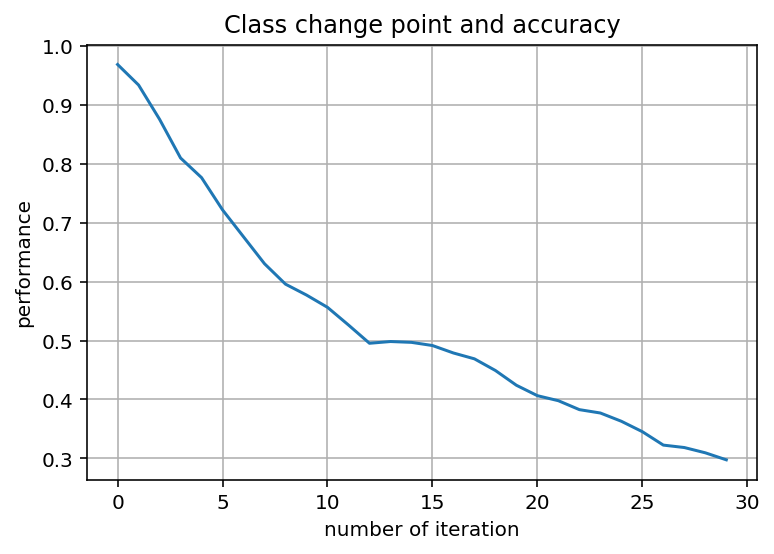

In [19]:
sum=[]
for i in ran:
    sum = torch.stack(scar, dim=1) 
avg_scar = torch.mean(sum,1)
plt.plot(avg_scar)
#plt.plot(avg)
plt.title('Class change point and accuracy')
plt.axis('tight')
plt.grid()
plt.xlabel('number of iteration')
plt.ylabel('performance')
#plt.savefig('lenet_emnist_compare.png',  bbox_inches='tight')
plt.show()

In [20]:

# parameters
# multiple input and taking their average

#binarization
binarization = binarization_otsu
#binarization = binarization_niblack

kk_a=[]   # confidence tensor
kk_d=[]
kk_s=[]
ch_a=[]   # attack succes rate regarding the number of pixels
ch_d=[]
ch_s=[]
ran = range(10)    # number of images to attack then taking the avarage
img_list = [0,4,5,7,8,9,10,11,17,22]
for z in img_list:
    image=images[z].numpy().squeeze()

    #binarization
    #binarization = binarization_global
    bwf1 = binarization(image)

    bwf=torch.flatten(torch.Tensor(bwf1))
    ############################################################################
    #calculate the confidence for vanila test input
    img = torch.Tensor(bwf).view(1, 1, 28, 28)
    test_output, last_layer = net(img.cuda())
    org_class = torch.max(test_output, 1)[1].unsqueeze(0).unsqueeze(0).cuda()
    #print(f'Prediction number: {org_class}')

    m = nn.Softmax(dim=1)
    bs=m(test_output)
    ps_org = torch.max(bs)  # confidence of original input
    # addition attack


    ##############################################################################
    #prepare perturbations
    pix=torch.arange(1,784)
    pert0 = torch.zeros(784,)
    adv_pix=[]
    psi=[]

    adv_cost=1  # at least how much decease on accuracy after each individual efficient pixel flipped 
    probs_all_a = []
    adv_ex=[]

    #calculate the effect of perturbation
    for i in pix:
        pert0 = torch.zeros(784,)
        pert0[i] = 1
        adv_ex1 = np.array(bwf + pert0)
        adv_ex2 = binarization(adv_ex1)
        adv_ex=torch.Tensor(adv_ex2).view(1, 1, 28, 28)

        test_output, last_layer = net(adv_ex.cuda())
        pred_class = torch.max(test_output, 1)[1].unsqueeze(0).unsqueeze(0).cuda()
        m = nn.Softmax(dim=1)
        bs=m(test_output)
        bs_pred = torch.max(bs)        #test_output[:,9]
        if bs_pred<ps_org:
            psi.append(bs_pred)
            adv_pix.append(i)
    ####################################################################
    # adding efficinet pert to zero vector

    pert0 = torch.zeros(784,)

    psi1=torch.Tensor(psi)
    adv_pix1=torch.Tensor(adv_pix)

    psi1=torch.sort(torch.Tensor(psi),descending=False) # sorting the losses from max to min

    #####################################################################
    # finding biggest impact pixels by using biggest loss 
    #sortng
    sorted_pixa = adv_pix1.gather(dim=0, index=psi1[1])
    #print(sorted_pix)

    for i in range(30):
        m= sorted_pixa[0:i]
        t= m.to(torch.int)

        for ii in t:
            pert0[ii] =1

        pert0_a=pert0
        adv_ex1 = np.array(bwf + pert0_a)
        adv_ex2 = binarization(adv_ex1)
        adv_ex=torch.Tensor(adv_ex2).view(1, 1, 28, 28)
        adv_ex.shape
        test_output, last_layer = net(adv_ex.cuda())
        pred_class = torch.max(test_output, 1)[1].unsqueeze(0).unsqueeze(0).cuda()
        if pred_class !=  org_class:
            ch_a.append(np.count_nonzero(pert0_a))
            #break
            
        m = nn.Softmax(dim=1)
        bs=m(test_output)
        #bs_pred = torch.max(bs)        #test_output[:,9]
        bs_pred = bs[:,org_class]
        for p in range(1):
            probs_all_a.append(bs_pred)
        adv_ex=torch.Tensor(adv_ex).view(28, 28)
        #plt.imshow(adv_ex,cmap='gray')
    sss_a=torch.Tensor(probs_all_a).cpu()
    for y in range(1):
        kk_a.append(torch.Tensor(sss_a))
##########################################################################################
#### deletion attack######################################################################
    
    image=images[z].numpy().squeeze()

    #binarization
    #binarization = binarization_global
    bwf1 = binarization(image)

    bwf=torch.flatten(torch.Tensor(bwf1))
    ############################################################################
    #calculate the confidence for vanila test input
    img = torch.Tensor(bwf).view(1, 1, 28, 28)
    test_output, last_layer = net(img.cuda())
    org_class = torch.max(test_output, 1)[1].unsqueeze(0).unsqueeze(0).cuda()
    #print(f'Prediction number: {org_class}')

    m = nn.Softmax(dim=1)
    bs=m(test_output)
    ps_org = torch.max(bs)  # confidence of original input

    ##############################################################################
    #prepare perturbations
    pix=torch.arange(1,784)
    pert0 = torch.zeros(784,)
    adv_pix=[]
    psi=[]

    adv_cost=1  
    probs_all_d = []
    for i in pix:
        pert0 = torch.zeros(784,)
        pert0[i] = -1
        adv_ex1 = np.array(bwf + pert0)
        adv_ex2 = binarization(adv_ex1)
        adv_ex=torch.Tensor(adv_ex2).view(1, 1, 28, 28)

        test_output, last_layer = net(adv_ex.cuda())
        pred_class = torch.max(test_output, 1)[1].unsqueeze(0).unsqueeze(0).cuda()
        #print(f'Prediction number: {pred_class}')
        #x = test_output
        #bs = (x-torch.min(x))/(torch.max(x)-torch.min(x))
        #ps_org = torch.max(bs)
        m = nn.Softmax(dim=1)
        bs=m(test_output)
        bs_pred = torch.max(bs)        #test_output[:,9]
        if bs_pred<ps_org:
            psi.append(bs_pred)
            adv_pix.append(i)
    #print('efficient adv pixels:', adv_pix)
    #print('finally accuracy after each pert:', np.transpose(psi))
    # adding efficinet pert to zero vector

    pert0 = torch.zeros(784,)

    psi1=torch.Tensor(psi)
    adv_pix1=torch.Tensor(adv_pix)

    psi1=torch.sort(torch.Tensor(psi),descending=False) # sorting the losses from max to min

    # finding biggest impact pixels by using biggest loss 

    sorted_pixd = adv_pix1.gather(dim=0, index=psi1[1])
    #print(sorted_pix)

    for i in range(30):
        m= sorted_pixd[0:i]
        t= m.to(torch.int)

        for i in t:
            pert0[i] =-1

        pert0_d=pert0
        adv_ex1 = np.array(bwf + pert0_d)
        adv_ex2 = binarization(adv_ex1)
        adv_ex=torch.Tensor(adv_ex2).view(1, 1, 28, 28)
        adv_ex.shape
        test_output, last_layer = net(adv_ex.cuda())
        pred_class = torch.max(test_output, 1)[1].unsqueeze(0).unsqueeze(0).cuda()
        if pred_class !=  org_class:
            ch_d.append(np.count_nonzero(pert0_d))
            #break
        #print(f'Prediction number: {pred_class}')
        #x = test_output
        #bs = (x-torch.min(x))/(torch.max(x)-torch.min(x))
        #ps_org = torch.max(bs)
        m = nn.Softmax(dim=1)
        bs=m(test_output)
        #bs_pred = torch.max(bs)        #test_output[:,9]
        bs_pred = bs[:,org_class]
        for p in range(1):
            probs_all_d.append(bs_pred)
        adv_ex=torch.Tensor(adv_ex).view(28, 28)
        #plt.imshow(adv_ex,cmap='gray')
    sss_d=torch.Tensor(probs_all_d).cpu()
    #plt.plot(sss_d)
    for y in range(1):
        kk_d.append(torch.Tensor(sss_d))
        
    #plt.plot(sss_a)
#######################################################################################    
        # shifting attack with varying k

    pert00 = np.zeros(784,)

    k=   np.arange(30)#5
    probs_all_s=[]
    for p in k:
        m= sorted_pixa[0:p]
        t= m.to(torch.int)
        mm= sorted_pixd[0:p]
        tt= mm.to(torch.int)

        for i in t:
            pert00[i] =1
        for i in tt:
            pert00[i] =-1

        pert0_s=pert00
        adv_ex1 = np.array(bwf + pert0_s)
        adv_ex2 = binarization(adv_ex1)
        adv_ex=torch.Tensor(adv_ex2)
        adv_ex.shape
        adv_ex=torch.Tensor(adv_ex2).view(1, 1, 28, 28)
        adv_ex.shape
        test_output, last_layer = net(adv_ex.cuda())
        pred_class = torch.max(test_output, 1)[1].unsqueeze(0).unsqueeze(0).cuda()
        if pred_class !=  org_class:
            ch_s.append(np.count_nonzero(pert0_s))
            #break
        #print(f'Prediction number: {pred_class}')
        #x = test_output
        #bs = (x-torch.min(x))/(torch.max(x)-torch.min(x))
        #ps_org = torch.max(bs)
        m = nn.Softmax(dim=1)
        bs=m(test_output)
        #bs_pred = torch.max(bs)        #test_output[:,9]
        bs_pred = bs[:,org_class]
        for p in range(1):
            probs_all_s.append(bs_pred)
        adv_ex=torch.Tensor(adv_ex).view(28, 28)
        #plt.imshow(adv_ex,cmap='gray')
    sss_s=torch.Tensor(probs_all_s).cpu()
    for y in range(1):
        kk_s.append(torch.Tensor(sss_s))
    #plt.plot(sss_s)


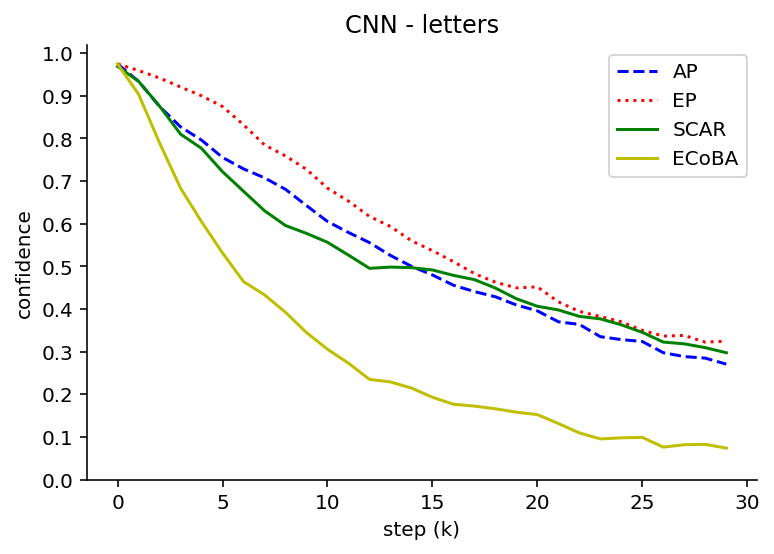

In [21]:
sum1=[]
sum2 =[]
sum3 = []

for i in ran:
    sum1 = torch.stack(kk_a, dim=1) 
avg_a = torch.mean(sum1,1)

for i in ran:
    sum2 = torch.stack(kk_d, dim=1) 
avg_d = torch.mean(sum2,1)

for i in ran:
    sum3 = torch.stack(kk_s, dim=1) 
avg_s = torch.mean(sum3,1)

%matplotlib inline

ax = plt.subplot(111)
plt.plot(avg_a,'b--',label='AP')
plt.plot(avg_d,'r:',label='EP')
plt.plot(avg_scar, 'g', label = 'SCAR')
plt.plot(avg_s,'y',label='ECoBA')

#plt.axvline(x=avg_kca,color='b', label='change point for ACA')
#plt.axvline(x=avg_kdc,color='r', label='change point for ECA')

leg= plt.legend()
leg= plt.legend()
plt.title('CNN - '+str(data_type))
plt.axis('tight')
#plt.grid()
plt.xlabel('step (k)')
plt.ylabel('confidence')

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# set the y-spine
ax.spines['bottom'].set_position('zero')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.savefig('CNN_letters.png')
plt.show()

In [22]:
str(data_type)

'letters'